In [1]:
import random 
from types import SimpleNamespace

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np

import torch
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
import sys
import os
from pathlib import Path

parent = Path(os.path.abspath("")).resolve().parents[0]
if parent not in sys.path:
    sys.path.insert(0, str(parent))
    
from ml.utils.data_utils import TorchDataset
from ml.utils.metrics import get_classification_metrics, get_probability_measures, get_lift_demotion_scores

from ml.models.autoencoder import AutoEncoder
from ml.models.mlp import MLP

In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
def merge_strings_and_integers(val):
    try:
        return int(val)
    except:
        return 'other'

In [5]:
df = pd.read_csv("final_autof.csv")
df.drop([
    'MODE(consumptions.MS_METER_NBR)',
    'MODE(representations.SUPPLIER)',
    'MODE(representations.SUPPLIER_TO)',
], axis=1, inplace=True)
df.dropna(subset=['number_of_zeros'], inplace=True)


df['MODE(consumptions.BS_RATE)'] = df['MODE(consumptions.BS_RATE)'].apply(merge_strings_and_integers)
df = df.drop(['rec_id'], axis=1)
df = df.drop_duplicates()
df['MODE(requests.REQUEST_TYPE)'] = df['MODE(requests.REQUEST_TYPE)'].replace(0, 'unknown')
df = pd.get_dummies(df, columns=['MODE(requests.REQUEST_TYPE)'], prefix='MODE(requests.REQUEST_TYPE)')
df = pd.get_dummies(df, columns=['MODE(consumptions.BS_RATE)'], prefix='MODE(consumptions.BS_RATE)')
df = df.drop(['voltage'], axis=1)
df.fillna(0, inplace=True)
df.head()

/tmp/ipykernel_5638/3053899110.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("final_autof.csv")


,COUNT(consumptions),MAX(consumptions.CSS_MS_HS_USE),MEAN(consumptions.CSS_MS_HS_USE),MIN(consumptions.CSS_MS_HS_USE),NUM_UNIQUE(consumptions.BS_RATE),NUM_UNIQUE(consumptions.MS_METER_NBR),SKEW(consumptions.CSS_MS_HS_USE),STD(consumptions.CSS_MS_HS_USE),SUM(consumptions.CSS_MS_HS_USE),MODE(consumptions.DAY(MEASUREMENT_DATE)),...,MODE(consumptions.BS_RATE)_40,MODE(consumptions.BS_RATE)_41,MODE(consumptions.BS_RATE)_42,MODE(consumptions.BS_RATE)_43,MODE(consumptions.BS_RATE)_44,MODE(consumptions.BS_RATE)_52,MODE(consumptions.BS_RATE)_53,MODE(consumptions.BS_RATE)_54,MODE(consumptions.BS_RATE)_55,MODE(consumptions.BS_RATE)_other
0,4.0,135.0,64.250000,12.0,1.0,1.0,0.758461,54.389797,257.0,2.0,...,0,0,0,0,0,0,0,0,0,0
1,10.0,127.0,51.900000,0.0,1.0,2.0,0.783315,43.072162,519.0,2.0,...,0,0,0,0,0,0,0,0,0,0
2,12.0,6068.0,3924.166667,2446.0,1.0,1.0,0.574519,1012.516472,47090.0,28.0,...,0,0,0,0,0,0,0,0,0,0
3,6.0,1061.0,479.333333,7.0,2.0,1.0,0.020392,409.340282,2876.0,4.0,...,0,0,0,0,0,0,0,0,0,0
4,24.0,1247.0,536.833333,0.0,2.0,1.0,0.537625,335.364392,12884.0,4.0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
list(df.columns)

['COUNT(consumptions)',
 'MAX(consumptions.CSS_MS_HS_USE)',
 'MEAN(consumptions.CSS_MS_HS_USE)',
 'MIN(consumptions.CSS_MS_HS_USE)',
 'NUM_UNIQUE(consumptions.BS_RATE)',
 'NUM_UNIQUE(consumptions.MS_METER_NBR)',
 'SKEW(consumptions.CSS_MS_HS_USE)',
 'STD(consumptions.CSS_MS_HS_USE)',
 'SUM(consumptions.CSS_MS_HS_USE)',
 'MODE(consumptions.DAY(MEASUREMENT_DATE))',
 'MODE(consumptions.MONTH(MEASUREMENT_DATE))',
 'MODE(consumptions.WEEKDAY(MEASUREMENT_DATE))',
 'MODE(consumptions.YEAR(MEASUREMENT_DATE))',
 'NUM_UNIQUE(consumptions.DAY(MEASUREMENT_DATE))',
 'NUM_UNIQUE(consumptions.MONTH(MEASUREMENT_DATE))',
 'NUM_UNIQUE(consumptions.WEEKDAY(MEASUREMENT_DATE))',
 'NUM_UNIQUE(consumptions.YEAR(MEASUREMENT_DATE))',
 'COUNT(representations)',
 'NUM_UNIQUE(representations.SUPPLIER)',
 'NUM_UNIQUE(representations.SUPPLIER_TO)',
 'MODE(representations.DAY(END_DATE))',
 'MODE(representations.MONTH(END_DATE))',
 'MODE(representations.WEEKDAY(END_DATE))',
 'MODE(representations.YEAR(END_DATE))',
 '

In [6]:
df = df.drop_duplicates()
print(len(df.loc[df.target == 1]))
df.head()

1552


,COUNT(consumptions),MAX(consumptions.CSS_MS_HS_USE),MEAN(consumptions.CSS_MS_HS_USE),MIN(consumptions.CSS_MS_HS_USE),NUM_UNIQUE(consumptions.BS_RATE),NUM_UNIQUE(consumptions.MS_METER_NBR),SKEW(consumptions.CSS_MS_HS_USE),STD(consumptions.CSS_MS_HS_USE),SUM(consumptions.CSS_MS_HS_USE),MODE(consumptions.DAY(MEASUREMENT_DATE)),...,MODE(consumptions.BS_RATE)_40,MODE(consumptions.BS_RATE)_41,MODE(consumptions.BS_RATE)_42,MODE(consumptions.BS_RATE)_43,MODE(consumptions.BS_RATE)_44,MODE(consumptions.BS_RATE)_52,MODE(consumptions.BS_RATE)_53,MODE(consumptions.BS_RATE)_54,MODE(consumptions.BS_RATE)_55,MODE(consumptions.BS_RATE)_other
0,4.0,135.0,64.250000,12.0,1.0,1.0,0.758461,54.389797,257.0,2.0,...,0,0,0,0,0,0,0,0,0,0
1,10.0,127.0,51.900000,0.0,1.0,2.0,0.783315,43.072162,519.0,2.0,...,0,0,0,0,0,0,0,0,0,0
2,12.0,6068.0,3924.166667,2446.0,1.0,1.0,0.574519,1012.516472,47090.0,28.0,...,0,0,0,0,0,0,0,0,0,0
3,6.0,1061.0,479.333333,7.0,2.0,1.0,0.020392,409.340282,2876.0,4.0,...,0,0,0,0,0,0,0,0,0,0
4,24.0,1247.0,536.833333,0.0,2.0,1.0,0.537625,335.364392,12884.0,4.0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
print("Bincount of y:", df['target'].value_counts())

Bincount of y: 0.0    698967
1.0      1552
Name: target, dtype: int64


In [8]:
train, val = train_test_split(
    df, test_size=0.2, 
    random_state=42, shuffle=True, 
    stratify=df.target.values)

In [9]:
train.target.value_counts(), val.target.value_counts()

(0.0    559173
 1.0      1242
 Name: target, dtype: int64,
 0.0    139794
 1.0       310
 Name: target, dtype: int64)

In [10]:
X_train = train.drop('target', axis=1)
y_train = train['target']
X_val = val.drop('target', axis=1)
y_val = val['target']

In [11]:
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

In [12]:
train_dataset = TorchDataset(
    X=torch.tensor(X_train).float(),
    y=torch.tensor(y_train.to_numpy()).float()
)  # reconstruction
val_dataset = TorchDataset(
    X=torch.tensor(X_val).float(),
    y=torch.tensor(y_val.to_numpy()).float()
)

In [13]:
np.bincount(y_train), np.bincount(y_val)

(array([559173,   1242]), array([139794,    310]))

In [14]:
train_loader = DataLoader(
    train_dataset, batch_size=512, shuffle=False
)
val_loader = DataLoader(
    val_dataset, batch_size=512, shuffle=False
)

In [15]:
encoder = MLP(
    in_size=X_train.shape[1],
    layer_units=[64],
    out_size=32,
    vae=False) # do not use VAE
decoder = MLP(
    in_size=32, 
    layer_units=[64],
    out_size=X_train.shape[1]
)
classifier = MLP(
    in_size=X_train.shape[1],
    layer_units=[32, 64],
    out_size=1,
    init_weights=False
)
model = AutoEncoder(encoder, decoder, classifier=classifier) # make it an AutoEncoder-based classifier.
model

AutoEncoder(
  (encoder): MLP(
    (MLP): Sequential(
      (0): Linear(in_features=88, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (decoder): MLP(
    (MLP): Sequential(
      (0): Linear(in_features=32, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=88, bias=True)
    )
  )
  (classifier): MLP(
    (MLP): Sequential(
      (0): Linear(in_features=88, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

In [16]:
optimizer = torch.optim.Adam(model.parameters(), 
                                 lr=1e-3)
criterion = torch.nn.BCEWithLogitsLoss()
device = 'cpu'
print(device)
    
args = dict(
    model=model,
    train_loader=train_loader, 
    test_loader=val_loader,
    epochs=5, 
    optimizer=optimizer, 
    criterion=criterion,
    reconstruction=False,
    vae=False,
    device=device,
    verbose=True, 
    return_best=True,
    plot_history=True,
    num_test_samples=100
)

cpu


Epoch: 1/5
[Train]	Loss=0.027047121060318972, Accuracy: 0.9977837852305881, Precision: 0.0, Recall: 0.0, F1: 0.0
		Brier score loss: 0.002204095598180607, ROC-AUC: 0.8280342450630731, PR-AUC: 0.014587280682164831
		Lift: 0.07, Demotion: 1.0, Weighted Score: 0.349
[Test]	Loss=0.017802508547902107, Accuracy: 0.9977873579626563, Precision: 0.0, Recall: 0.0, F1: 0.0
		Brier score loss: 0.0022010393272768234, ROC-AUC: 0.8206967094900469, PR-AUC: 0.016138812926380038
		Lift: 0.03, Demotion: 1.0, Weighted Score: 0.321

Epoch: 2/5
[Train]	Loss=0.013942869430775733, Accuracy: 0.9977837852305881, Precision: 0.0, Recall: 0.0, F1: 0.0
		Brier score loss: 0.002183056282520547, ROC-AUC: 0.8702924934005009, PR-AUC: 0.04608634590312404
		Lift: 0.31, Demotion: 1.0, Weighted Score: 0.517
[Test]	Loss=0.017268972471356392, Accuracy: 0.9977873579626563, Precision: 0.0, Recall: 0.0, F1: 0.0
		Brier score loss: 0.0021798072726212075, ROC-AUC: 0.870751490557304, PR-AUC: 0.03643385279652138
		Lift: 0.12, Demot

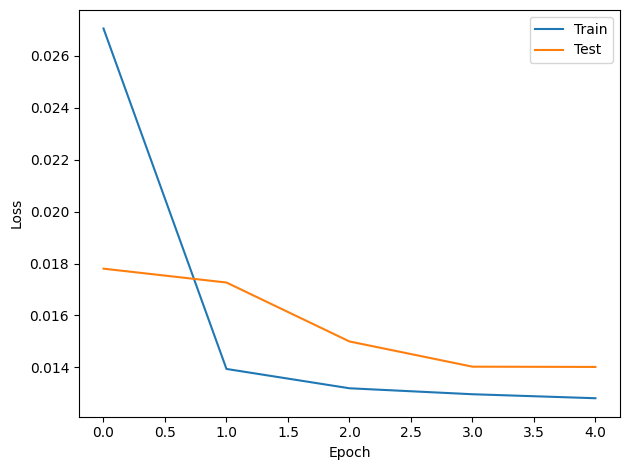

In [17]:
args = SimpleNamespace(**args)
model = model.fit(args)

In [18]:
df.head()

,COUNT(consumptions),MAX(consumptions.CSS_MS_HS_USE),MEAN(consumptions.CSS_MS_HS_USE),MIN(consumptions.CSS_MS_HS_USE),NUM_UNIQUE(consumptions.BS_RATE),NUM_UNIQUE(consumptions.MS_METER_NBR),SKEW(consumptions.CSS_MS_HS_USE),STD(consumptions.CSS_MS_HS_USE),SUM(consumptions.CSS_MS_HS_USE),MODE(consumptions.DAY(MEASUREMENT_DATE)),...,MODE(consumptions.BS_RATE)_40,MODE(consumptions.BS_RATE)_41,MODE(consumptions.BS_RATE)_42,MODE(consumptions.BS_RATE)_43,MODE(consumptions.BS_RATE)_44,MODE(consumptions.BS_RATE)_52,MODE(consumptions.BS_RATE)_53,MODE(consumptions.BS_RATE)_54,MODE(consumptions.BS_RATE)_55,MODE(consumptions.BS_RATE)_other
0,4.0,135.0,64.250000,12.0,1.0,1.0,0.758461,54.389797,257.0,2.0,...,0,0,0,0,0,0,0,0,0,0
1,10.0,127.0,51.900000,0.0,1.0,2.0,0.783315,43.072162,519.0,2.0,...,0,0,0,0,0,0,0,0,0,0
2,12.0,6068.0,3924.166667,2446.0,1.0,1.0,0.574519,1012.516472,47090.0,28.0,...,0,0,0,0,0,0,0,0,0,0
3,6.0,1061.0,479.333333,7.0,2.0,1.0,0.020392,409.340282,2876.0,4.0,...,0,0,0,0,0,0,0,0,0,0
4,24.0,1247.0,536.833333,0.0,2.0,1.0,0.537625,335.364392,12884.0,4.0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
tmp_df = df.copy()

In [20]:
def get_loss_and_hidden(row, model):
    model.eval()
    model.to('cpu') # move model to cpu
    tmp_X = row.drop('target') # get the features
    target = row.target # get the target
    input_tensor = torch.tensor(tmp_X.values, dtype=torch.float32) # transform to torch tensor
    target = torch.tensor(target, dtype=torch.float32)
    
    encoded = model.encode(input_tensor) # get the latent
    decoded = model(input_tensor) # get the prediction
    loss = torch.nn.functional.binary_cross_entropy_with_logits(decoded[0], target) # calculate the loss
    
    return loss.item(), encoded.detach().numpy().tolist()

In [21]:
X = tmp_df.drop(['target'], axis=1)
X = scaler.transform(X)
y = tmp_df['target'].values
cols = list(df.columns)
cols.remove("target")
tmp = pd.DataFrame(X, columns=cols)
tmp['target'] = y

In [22]:
tmp[['loss', 'hidden']] = tmp.apply(lambda row: pd.Series(get_loss_and_hidden(row, model)), axis=1)
tmp.drop(['loss'], axis=1, inplace=True)

In [23]:
tmp.head()

,COUNT(consumptions),MAX(consumptions.CSS_MS_HS_USE),MEAN(consumptions.CSS_MS_HS_USE),MIN(consumptions.CSS_MS_HS_USE),NUM_UNIQUE(consumptions.BS_RATE),NUM_UNIQUE(consumptions.MS_METER_NBR),SKEW(consumptions.CSS_MS_HS_USE),STD(consumptions.CSS_MS_HS_USE),SUM(consumptions.CSS_MS_HS_USE),MODE(consumptions.DAY(MEASUREMENT_DATE)),...,MODE(consumptions.BS_RATE)_42,MODE(consumptions.BS_RATE)_43,MODE(consumptions.BS_RATE)_44,MODE(consumptions.BS_RATE)_52,MODE(consumptions.BS_RATE)_53,MODE(consumptions.BS_RATE)_54,MODE(consumptions.BS_RATE)_55,MODE(consumptions.BS_RATE)_other,target,hidden
0,0.025862,0.000036,0.000064,0.000012,0.00,0.0,0.382790,0.000083,0.000043,0.033333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.10194499045610428, 0.3561626076698303, 0.63..."
1,0.077586,0.000034,0.000052,0.000000,0.00,0.2,0.384822,0.000066,0.000087,0.033333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.245834082365036, 0.408884733915329, 0.55154..."
2,0.094828,0.001637,0.003924,0.002446,0.00,0.0,0.367747,0.001549,0.007935,0.900000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-0.02126614935696125, 0.28791406750679016, 1...."
3,0.043103,0.000286,0.000479,0.000007,0.25,0.0,0.322431,0.000626,0.000485,0.100000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-0.30053916573524475, -0.2599944472312927, 1...."
4,0.198276,0.000336,0.000537,0.000000,0.25,0.0,0.364730,0.000513,0.002171,0.100000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-0.19244776666164398, 0.1723465919494629, 0.8..."


In [24]:
len(tmp)

700519

In [25]:
tmp.head()

,COUNT(consumptions),MAX(consumptions.CSS_MS_HS_USE),MEAN(consumptions.CSS_MS_HS_USE),MIN(consumptions.CSS_MS_HS_USE),NUM_UNIQUE(consumptions.BS_RATE),NUM_UNIQUE(consumptions.MS_METER_NBR),SKEW(consumptions.CSS_MS_HS_USE),STD(consumptions.CSS_MS_HS_USE),SUM(consumptions.CSS_MS_HS_USE),MODE(consumptions.DAY(MEASUREMENT_DATE)),...,MODE(consumptions.BS_RATE)_42,MODE(consumptions.BS_RATE)_43,MODE(consumptions.BS_RATE)_44,MODE(consumptions.BS_RATE)_52,MODE(consumptions.BS_RATE)_53,MODE(consumptions.BS_RATE)_54,MODE(consumptions.BS_RATE)_55,MODE(consumptions.BS_RATE)_other,target,hidden
0,0.025862,0.000036,0.000064,0.000012,0.00,0.0,0.382790,0.000083,0.000043,0.033333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.10194499045610428, 0.3561626076698303, 0.63..."
1,0.077586,0.000034,0.000052,0.000000,0.00,0.2,0.384822,0.000066,0.000087,0.033333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.245834082365036, 0.408884733915329, 0.55154..."
2,0.094828,0.001637,0.003924,0.002446,0.00,0.0,0.367747,0.001549,0.007935,0.900000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-0.02126614935696125, 0.28791406750679016, 1...."
3,0.043103,0.000286,0.000479,0.000007,0.25,0.0,0.322431,0.000626,0.000485,0.100000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-0.30053916573524475, -0.2599944472312927, 1...."
4,0.198276,0.000336,0.000537,0.000000,0.25,0.0,0.364730,0.000513,0.002171,0.100000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-0.19244776666164398, 0.1723465919494629, 0.8..."


In [26]:
tmp2 = pd.DataFrame(tmp['hidden'].apply(pd.Series).values, columns=[f't_hidden_{i}' for i in range(1, 33)])

In [27]:
tmp3 = pd.concat([tmp, tmp2], axis=1)

In [28]:
tmp3.head()

,COUNT(consumptions),MAX(consumptions.CSS_MS_HS_USE),MEAN(consumptions.CSS_MS_HS_USE),MIN(consumptions.CSS_MS_HS_USE),NUM_UNIQUE(consumptions.BS_RATE),NUM_UNIQUE(consumptions.MS_METER_NBR),SKEW(consumptions.CSS_MS_HS_USE),STD(consumptions.CSS_MS_HS_USE),SUM(consumptions.CSS_MS_HS_USE),MODE(consumptions.DAY(MEASUREMENT_DATE)),...,t_hidden_23,t_hidden_24,t_hidden_25,t_hidden_26,t_hidden_27,t_hidden_28,t_hidden_29,t_hidden_30,t_hidden_31,t_hidden_32
0,0.025862,0.000036,0.000064,0.000012,0.00,0.0,0.382790,0.000083,0.000043,0.033333,...,-0.063089,0.895868,1.036562,0.390906,-1.161102,-0.378927,0.040881,-0.681896,-0.407356,-0.955088
1,0.077586,0.000034,0.000052,0.000000,0.00,0.2,0.384822,0.000066,0.000087,0.033333,...,-0.090204,-0.194019,0.215788,0.507432,-0.359285,-1.185104,0.292332,-0.752195,-0.358941,-0.070556
2,0.094828,0.001637,0.003924,0.002446,0.00,0.0,0.367747,0.001549,0.007935,0.900000,...,-0.374836,0.747844,0.739037,0.711159,-1.119252,-0.721118,0.434841,-1.324009,-0.585363,-0.698145
3,0.043103,0.000286,0.000479,0.000007,0.25,0.0,0.322431,0.000626,0.000485,0.100000,...,-0.334390,0.654911,1.215230,0.464070,-1.498648,-0.330360,0.367574,-1.548556,-0.142071,-0.364654
4,0.198276,0.000336,0.000537,0.000000,0.25,0.0,0.364730,0.000513,0.002171,0.100000,...,-0.671520,-0.151803,0.587481,0.785575,-0.804113,-0.575369,0.181546,-1.083758,-0.000248,0.167582


In [29]:
tmp3.drop(['hidden'], axis=1, inplace=True)

In [30]:
tmp3.head()

,COUNT(consumptions),MAX(consumptions.CSS_MS_HS_USE),MEAN(consumptions.CSS_MS_HS_USE),MIN(consumptions.CSS_MS_HS_USE),NUM_UNIQUE(consumptions.BS_RATE),NUM_UNIQUE(consumptions.MS_METER_NBR),SKEW(consumptions.CSS_MS_HS_USE),STD(consumptions.CSS_MS_HS_USE),SUM(consumptions.CSS_MS_HS_USE),MODE(consumptions.DAY(MEASUREMENT_DATE)),...,t_hidden_23,t_hidden_24,t_hidden_25,t_hidden_26,t_hidden_27,t_hidden_28,t_hidden_29,t_hidden_30,t_hidden_31,t_hidden_32
0,0.025862,0.000036,0.000064,0.000012,0.00,0.0,0.382790,0.000083,0.000043,0.033333,...,-0.063089,0.895868,1.036562,0.390906,-1.161102,-0.378927,0.040881,-0.681896,-0.407356,-0.955088
1,0.077586,0.000034,0.000052,0.000000,0.00,0.2,0.384822,0.000066,0.000087,0.033333,...,-0.090204,-0.194019,0.215788,0.507432,-0.359285,-1.185104,0.292332,-0.752195,-0.358941,-0.070556
2,0.094828,0.001637,0.003924,0.002446,0.00,0.0,0.367747,0.001549,0.007935,0.900000,...,-0.374836,0.747844,0.739037,0.711159,-1.119252,-0.721118,0.434841,-1.324009,-0.585363,-0.698145
3,0.043103,0.000286,0.000479,0.000007,0.25,0.0,0.322431,0.000626,0.000485,0.100000,...,-0.334390,0.654911,1.215230,0.464070,-1.498648,-0.330360,0.367574,-1.548556,-0.142071,-0.364654
4,0.198276,0.000336,0.000537,0.000000,0.25,0.0,0.364730,0.000513,0.002171,0.100000,...,-0.671520,-0.151803,0.587481,0.785575,-0.804113,-0.575369,0.181546,-1.083758,-0.000248,0.167582


In [31]:
final = tmp3[['t_hidden_1', 't_hidden_2', 't_hidden_3', 't_hidden_4',
          't_hidden_5', 't_hidden_6', 't_hidden_7', 't_hidden_8',
          't_hidden_9', 't_hidden_10', 't_hidden_11', 't_hidden_12',
          't_hidden_13', 't_hidden_14', 't_hidden_15', 't_hidden_16',
          't_hidden_17', 't_hidden_18', 't_hidden_19', 't_hidden_20',
          't_hidden_21', 't_hidden_22', 't_hidden_23', 't_hidden_24',
          't_hidden_25', 't_hidden_26', 't_hidden_27', 't_hidden_28',
          't_hidden_29', 't_hidden_30', 't_hidden_31', 't_hidden_32']]

In [32]:
len(df), len(final)

(700519, 700519)

In [33]:
#final.to_csv("autoencoder_classifier_loss_encoded.csv", index=False)